# Hotel Rating Prediction
In this project we will inspect the question   
whether we can or can not predict the overall rating on a given hotel  
according to different parameters which we already know (such as food rating, location rating etc.)

## Importing Dependencies

the next block will be responsible for installing and importing
the necessary libraries and functions.

In [5]:
# First lets import the libraries we need :
import requests
import pandas as pd
import numpy as np
import scipy as sc
from bs4 import BeautifulSoup
import time
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from collections import Counter
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


# The next command will be responsible to display graphs in our notebook.
%matplotlib inline

# Data Acquisition 

At this step we are going to acquire the data we need from the website "Booking.com",  
in order to build our DataFrame.  
Booking.com does not provide an API, so the method we will be using is "Crawling",  
that will iterate all pages and objects to access the required data.

## Crawling 

We will now fetch what we need from the website "Booking.com",  
by inspecting the source code of each page and understanding the structure of the objects (hotels)  


In [6]:
# creating the function to load a beautifulsoup object that we can work on.
def load_soup_object(link):
    response_link = requests.get(link ,headers=0)
    soup_object = BeautifulSoup(response_link.content, "html.parser")
    return soup_object


In [ ]:
# Lets get the URL and parse it before we create our DataFrame
URL = "https://www.booking.com/he"
soup = load_soup_object(URL)

# Now we will create the lists that will serve as the columns for the DataFrame
Hotel_Name = []
Staff_Rating = []
Facilities_Rating = []
Cleanliness_Rating = []
Comfort_Rating = []
Value_For_Money_Rating = []
Location_Rating = []
Free_WiFi_Rating = []
Final_Grade = []



# accessing the class that contains the list of regions - not only in israel 
# and creating a list of known cities to be extracted 
# counter will be used to save the index of the desired regions - then to specify the index withing the 'searches' list

searches = soup.find(class_="ia_section-container clearfix wcu-seo-regions-poi").find_all('a')
cities = ["אזור ירושלים","אזור המרכז","גליל","גליל עליון","כנרת","אזור תל אביב","דרום הארץ","ים המלח","נגב","צפון הארץ","רמת הגולן"]
names = []
indexes = []
href_list = []
counter = 0
# now, 'searches' is a list with all the regions,we want to loop through and extract only the ones we want
# first, we are getting the name of each object in the list, and checking if it exists in our desired regeions list 'cities'
# if the term is met, we are appending the corresponding index(integer) to the indexes list
# and extracting the corresponding link with the "href" tag and concatanating it to the original URL
for i in searches:
    name1 = i.get_text().replace("\n", "") 
    if name1 in cities:
        names.append(name1)
        indexes.append(counter)
        href = searches[counter].get("href").strip() # getting the link for a specific region that matches our 'cities' list
        URL2 = URL+href
        soup2 = load_soup_object(URL2)
        
        # now that we have the full link to the specific region
        # lets parse it so we can inspect and work with each page 
        # each region`s page has a specific "Watch all" link that needs to be accessed
        # therefore, we are accessing the class that contains the only object(link) we need
        # and concatanating the link to the original URL
        
        searches2 = soup2.find(class_="lp-bui-section bui-spacer--largest x2").find_all("a")
        print("counter is : ", counter)
        print("region is : ", name1)
        nexthref = URL + searches2[0].get("href").strip()
        print("full name : ", searches2[0].get_text())
        href_list.append(nexthref)
        print("\nhref is :\n",nexthref, "\n")
    counter+=1

# now after this for loop we have a list that contains all the links to the full page of each desired region

print(names)
print(indexes)


    
    

Now after we have a list of the correct and desired regions,  
we are going to access each region's page and loop through all other pages  
so we can extract the information we need regarding each item(hotel) in the page.

In [7]:
# in the next block we will define the function that will adjust links
# to help us move between pages inside our website
# url_num : is the variable responsible to indicate which page we are going to display (1st page = 25, 2nd page = 50...)
# url_num_flag : is the variable that we will use to know how to "cut" the link string i.e after 3 iterations 
#                                    we will have the number 100 so we need to cut 3 digits instead of 5
# offset_flag : is the variable that will indicate whether the 1st page`s link ends with &offset=25 OR just &
# region counter is not critical to the code - just counting how many links starting with "offset"
# using global keyword to be able to update values that exist outside of the funtion 

def adjust_link():
    global link
    global url_num
    global offset_flag
    global url_num_flag
    global region_counter
    if offset_flag == 0: # flag == 0 ---> // first page is link is : https://dfsdfs&offset=25
            region_counter += 1
            print("with offset for link is : ", link)
            print("url flag is : ", url_num_flag)
            if url_num_flag >= 39:
                link = link[:-4]
                link += str(url_num)
                url_num += 25

            elif url_num_flag >= 3:
                link = link[:-3]
                link += str(url_num)
                url_num += 25

            else:
                link = link[:-2]
                link += str(url_num)
                url_num += 25

    else: # flag == 1 ---> // first page is link is : https://dfsdfs&
        region_counter -= 1
        link += "offset=25"
        offset_flag = 0
        url_num += 25
    url_num_flag += 1
    return link
        

In [ ]:
# now that we have all the links to all regions(north, negev etc.),
# we need to parse each one with html.parser so we can work with it
counter2 = 0
region_counter = 0 # will count how many regions are starting with offset
for link in href_list: #i.e north, south, negev
    
    # url_num_flag will tell us how do we need to cut the link to adjust it for next pages
    # url_num will be the indicator for which page we want to fetch --> 1st page will be 25, 2nd will be 50....
    url_num_flag = 0
    url_num = 50
    #some pages links starts with an "offset" after the last & in the link, and some not, we need to check this with flag
    offset_flag = 0
    if link[-1] == "&":
        offset_flag = 1
        url_num_flag -= 1
        url_num -= 25
    # PRINTING FOR CHECK print("prime link is : ", link)
    city_soup = load_soup_object(link)
    number_of_pages = int(city_soup.find(class_="d493c719bc").find_all('li')[-1].get_text())
    for i in range(number_of_pages-1):
        # PRINTING FOR CHECK print("page is : ", i+1)
        # PRINTING FOR CHECK print("page link is : ", link)
        city_soup2 = load_soup_object(link)
        
        # find all links(names links) for all hotels in the page into a list.
        try:
            hotels = city_soup2.find(class_="d4924c9e74").find_all('h3')
        except:
            adjust_link()
            continue
        # PRINTING FOR CHECK print("len hotels : ", len(hotels))
        
        # now we start extracting information for the dataframe. we start by taking the hotel names into the hotel name list
        for item in hotels: # looping through the h3 class for the hotels --- item == href of single hotel
            # PRINTING FOR CHECK print("current hotel is in page : ", i+1)
            # flag will indicate if our 7 parameters exist 
            flag = 0
            # PRINTING FOR CHECK print("hotel : ",item.a.find(class_="fcab3ed991 a23c043802").get_text())
            hotel_eng_name = ""
            
            #if the hotel name is in hebrew - we will now fetch the english name for it - straight from the URL
            # because the hotel name starts after the 33rd character in the URL
            item_for_name = item.a.get("href").strip()[33:]
            for s in item_for_name:
                if s == ".":
                    break
                hotel_eng_name += s
            Hotel_Name.append(hotel_eng_name)
            # PRINTING FOR CHECK print("hotel in english : ", hotel_eng_name)
            # PRINTING FOR CHECK print("hotel link is :",item.a.get("href").strip())
            hotel_soup = load_soup_object(item.a.get("href").strip()) #loading the soup object of single hotel link
            
            # the grade of the hotel is in a seperate place from other parameters - lets extract the final grade.
            try:
                hotel_grade = hotel_soup.find('div',
                                   attrs={"class" : "a1b3f50dcd b2fe1a41c3 a1f3ecff04 db7f07f643 d19ba76520 f4e25490ec"})
                hotel_grade2 = hotel_grade.find(class_="b5cd09854e d10a6220b4").get_text()
            except:
                hotel_grade2 = 0
            Final_Grade.append(hotel_grade2)

            #now lets get inside the link of the current hotel - and fetch the information for our DataFrame
            hotel_props = hotel_soup.select(".v2_review-scores__body.v2_review-scores__body--compared_to_average li")
            hotel_props2 = hotel_props[14:]
            # PRINTING FOR CHECK print("hotel props len is : ", len(hotel_props2))
            
            # next block will check for errors in the data we want to scrape, in case of an error or missing data
            # we will fill the values with 0.
            # flag = 1 will indicate that our hotel has missing data.
            if (len(hotel_props2)) < 7:
                # PRINTING FOR CHECK print("problem in hotel : ", Hotel_Name[counter2])
                # PRINTING FOR CHECK print("hotel props : ", hotel_props2)
                flag = 1
            if flag == 1:
                Staff_Rating.append(0)
                Facilities_Rating.append(0)
                Cleanliness_Rating.append(0)
                Comfort_Rating.append(0)
                Value_For_Money_Rating.append(0)
                Location_Rating.append(0)
                Free_WiFi_Rating.append(0)
            else:
                Staff_Rating.append(hotel_props2[0].find(class_="c-score-bar__score").get_text())
                Facilities_Rating.append(hotel_props2[1].find(class_="c-score-bar__score").get_text())
                Cleanliness_Rating.append(hotel_props2[2].find(class_="c-score-bar__score").get_text())
                Comfort_Rating.append(hotel_props2[3].find(class_="c-score-bar__score").get_text())
                Value_For_Money_Rating.append(hotel_props2[4].find(class_="c-score-bar__score").get_text())
                Location_Rating.append(hotel_props2[5].find(class_="c-score-bar__score").get_text())
                Free_WiFi_Rating.append(hotel_props2[6].find(class_="c-score-bar__score").get_text())
        adjust_link()

    
dfdict = {"Hotel_Names":Hotel_Name,"Staff_Rating":Staff_Rating, "Facilities_Rating":Facilities_Rating, "Cleanliness_Rating":Cleanliness_Rating, "Comfort_Rating":Comfort_Rating, "Value_For_Money_Rating":Value_For_Money_Rating, "Location_Rating":Location_Rating, "Free_WiFi_Rating":Free_WiFi_Rating, "Final_Grade":Final_Grade}
df = pd.DataFrame(data=dfdict)
df.to_csv('./BookingHotels.csv')
df.style




    

## This is the end of the Data Acquisition section
#### In order to work more efficiently, we will now work on our csv that we saved to our computer.

#### As we can see below, the DataFrame has 9 columns :
     - one column for the name of the hotel
     - 8 columns for different parameters which store values between 0 - 10 as 'float'

In [8]:
# Lets read the csv with the help of pandas function. 
# We use the index_col=[0] to drop the column indexes brought by the CSV file and has nothing to do with
df = pd.read_csv('./BookingHotels.csv', index_col=[0])
df.head()

,Hotel_Names,Staff_Rating,Facilities_Rating,Cleanliness_Rating,Comfort_Rating,Value_For_Money_Rating,Location_Rating,Free_WiFi_Rating,Final_Grade
0,desert-view,9.4,9.0,8.9,9.2,9.0,9.1,9.2,8.9
1,eretz-zeelim,8.4,7.8,7.8,7.7,7.2,8.1,4.6,7.6
2,kibbutz-lotan-ecotourism,9.3,8.0,8.6,8.3,8.4,9.0,7.8,8.3
3,desert-iris,8.3,7.6,7.6,8.1,7.4,8.3,7.3,7.7
4,amazing-bedouin-hospitality,9.8,8.9,9.2,9.0,9.3,8.6,9.1,9.2


## Inspecting our DataFrame

#### As we can see Below :  
#### our complete DataFrame (after fetching data through Crawling) has 7999 rows, and 9 columns
    - 1 column store the hotel name as type 'Object'
    - 8 columns store values of type 'float'

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Hotel_Names             8000 non-null   object 
 1   Staff_Rating            8000 non-null   float64
 2   Facilities_Rating       8000 non-null   float64
 3   Cleanliness_Rating      8000 non-null   float64
 4   Comfort_Rating          8000 non-null   float64
 5   Value_For_Money_Rating  8000 non-null   float64
 6   Location_Rating         8000 non-null   float64
 7   Free_WiFi_Rating        8000 non-null   float64
 8   Final_Grade             8000 non-null   float64
dtypes: float64(8), object(1)
memory usage: 625.0+ KB


# Data Cleaning

In [5]:
# in this code block we will handle our data inside our DataFrame that is incompatibe with our desired data.
# first we will remove all missing data indicated by values of 0.0
# after that we will drop dupliacted rows and we can simply check that by checking if the Hotel Name appear more than once
# after that we will reset the indexes 
df2 = df[df.Comfort_Rating != 0.0]
df2 = df2.drop_duplicates(subset=['Hotel_Names'])
df2.reset_index(drop=True, inplace=True)
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Hotel_Names             1978 non-null   object 
 1   Staff_Rating            1978 non-null   float64
 2   Facilities_Rating       1978 non-null   float64
 3   Cleanliness_Rating      1978 non-null   float64
 4   Comfort_Rating          1978 non-null   float64
 5   Value_For_Money_Rating  1978 non-null   float64
 6   Location_Rating         1978 non-null   float64
 7   Free_WiFi_Rating        1978 non-null   float64
 8   Final_Grade             1978 non-null   float64
dtypes: float64(8), object(1)
memory usage: 139.2+ KB


# Data Visualizations

In [13]:
def one_dim_plot(sr, plot_type, axis):
    if plot_type == "bar":
        axis.bar(x = sr.index, height = sr.values)
    elif plot_type == "pie":
        axis.pie(x = sr.values, labels = sr.index)
    else:
        axis.plot(sr.index, sr.values)

In [8]:
def plot_frequent_elements(df, df_in_params):
    fig, axes = plt.subplots(nrows = 1, ncols = df_in_params.shape[1], figsize = (20, 5))
    for i in range(df_in_params.shape[1]):
        if df_in_params.loc[:, "plot_type"].iat[i] == "bar":
            axes[i].bar(x = get_frequent_elements(df, df_in_params.loc[:, "col_name"].iat[i], df_in_params.loc[:, "num_top_elements"].iat[i]).index,
            height = get_frequent_elements(df, df_in_params.loc[:, "col_name"].iat[i], df_in_params.loc[:, "num_top_elements"].iat[i]).values)
        elif df_in_params.loc[:, "plot_type"].iat[i] == "pie":
            axes[i].pie(x = get_frequent_elements(df, df_in_params.loc[:, "col_name"].iat[i], df_in_params.loc[:, "num_top_elements"].iat[i]).values,
            labels = get_frequent_elements(df, df_in_params.loc[:, "col_name"].iat[i], df_in_params.loc[:, "num_top_elements"].iat[i]).index)
        else:
            axes[i].plot(get_frequent_elements(df, df_in_params.loc[:, "col_name"].iat[i], df_in_params.loc[:, "num_top_elements"].iat[i]).index,
                        get_frequent_elements(df, df_in_params.loc[:, "col_name"].iat[i], df_in_params.loc[:, "num_top_elements"].iat[i]).values)

            
def get_frequent_elements(df, col_name, num_top_elements):
    most_frequent = df.value_counts(subset = col_name, sort = False, ascending = True)
    return most_frequent.sort_values(ascending = True)[(len(most_frequent) - num_top_elements):]


def cross_tabulation(df, col_name, other_col_name):
     return pd.crosstab(index = df[col_name], columns = df[other_col_name], normalize = "index")

In [10]:
def plot_cross_tabulation(df, col_names, other_col_name):
    fig, axes = plt.subplots(nrows = 1, ncols = len(col_names), figsize = (20, 5))
    for i in range(len(col_names)):
        ct = cross_tabulation(df, col_names[i], other_col_name)
        axes[i].plot(ct.index, ct.values)

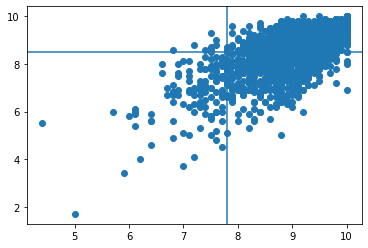

In [19]:
plt.scatter(df2.Location_Rating, df2.Final_Grade)
plt.axvline(df['Location_Rating'].median())
plt.axhline(df['Final_Grade'].median())

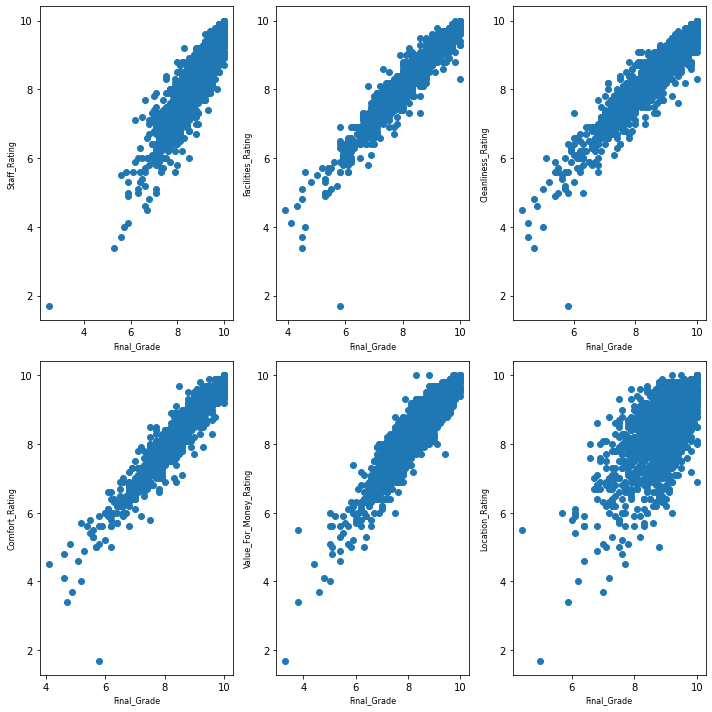

In [40]:
for i in range(1,7):
    firstcol = df.columns[i] # Location_Rating
    plt.subplot(2, 3, i)
    plt.gcf().set_size_inches((10, 10)) 
    plt.scatter(df2[firstcol], df2.Final_Grade)
    plt.ylabel(df2.columns[i],fontsize = 8)
    plt.xlabel('Final_Grade',fontsize = 8)
    
    
plt.tight_layout()